**Goal**: In this notebook, we want to better understand the mismatch between the theory and experiment.

Specifically, we analyse the errors induced by deconvolution:
- the misattributions (where mutations are assigned to the wrong signature),
- the reconstruction errors (where the spectrum is not faithfully decomposed).

In [1]:
from collections import defaultdict

from bearclaw.feature_extraction import POSSIBLE_SBS_SEQUENCING_ARTEFACTS
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd
from pandas import read_csv
import scipy as sp
import seaborn as sns
from statkit.types import Estimate
from statkit.views import format_p_value
from statsmodels.stats.multitest import fdrcorrection

In [2]:
# Add end-to-end package to path.
import sys
from pathlib import Path

sys.path.append(str(Path('../').absolute()))

from src.feature_extraction import COSMIC_MUTATIONAL_SIGNATURES, get_feature_names
from src.feature_extraction.step3.transform import CosmicNMF
from src.utils import kendall_tau_correlation

sbs_names = get_feature_names('single_base_substitutions', signatures=True)
substitution_names = get_feature_names('single_base_substitutions', signatures=False)

SBS = pd.read_csv(
    COSMIC_MUTATIONAL_SIGNATURES['single_base_substitutions'], sep='\t', index_col=0
).transpose()

In [3]:
# Load mutation spectra for the different panels.
kwargs = {
    'sep': r'\t',
    'index_col': 0,
}
X_hrtw_spctr = read_csv('../artifacts/hartwig_wes_spectrum.tsv', **kwargs)
# Also load the in silico spectra.
X_tso500_spctr = read_csv('../artifacts/hartwig_in_silico_tso500_spectrum.tsv', **kwargs)
X_f1cdx_spctr = read_csv('../artifacts/hartwig_in_silico_foundation_one_cdx_spectrum.tsv', **kwargs)
X_msk468_spctr = read_csv('../artifacts/hartwig_in_silico_msk_468_spectrum.tsv', **kwargs)
X_pancan_spctr = read_csv('../artifacts/hartwig_in_silico_pan_cancer_spectrum.tsv', **kwargs)

# Also compute the corresponding mutational signature attributions.
decomposer = CosmicNMF(cosmic_signature="single_base_substitutions", tol= 1e-9, max_iter=100_000)

X_hrtw = decomposer.transform(X_hrtw_spctr[substitution_names])
X_tso500 = decomposer.transform(X_tso500_spctr[substitution_names])
X_f1cdx = decomposer.transform(X_f1cdx_spctr[substitution_names])
X_msk468 = decomposer.transform(X_msk468_spctr[substitution_names])
X_pancan = decomposer.transform(X_pancan_spctr[substitution_names])

/tmp/ipykernel_13569/118413005.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  X_hrtw_spctr = read_csv('../artifacts/hartwig_wes_spectrum.tsv', **kwargs)
/tmp/ipykernel_13569/118413005.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  X_tso500_spctr = read_csv('../artifacts/hartwig_in_silico_tso500_spectrum.tsv', **kwargs)
/tmp/ipykernel_13569/118413005.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  X

In [4]:
def bootstrap_mean(x) -> Estimate:
    res = sp.stats.bootstrap((x,), np.mean, random_state=123)
    estimate = Estimate(
        np.mean(x),
        lower=res.confidence_interval.low,
        upper=res.confidence_interval.high,
    )
    return estimate

In [5]:
# Length of the panels in Megabases (Mb).
length_tso500 = 1.272_967
length_f1cdx = 1.335_884
length_msk468 = 1.848_194
length_pancan = 3.999_266

## Conservation of mutations

How well are the number of mutations conserved in the deconvolution process? Or, in other words, how large is the reconstructon error?

In [6]:
signature_spectrum_pairs = {
    "hrtw": (X_hrtw, X_hrtw_spctr),
    "tso500": (X_tso500, X_tso500_spctr),
    "f1cdx": (X_f1cdx, X_f1cdx_spctr),
    "msk468": (X_msk468, X_msk468_spctr),
    "pancan": (X_pancan, X_pancan_spctr),
}
# Per centage of (of total) misattributed substitutions due to NMF.
n_attribution_error = pd.DataFrame(
    0.0, index=signature_spectrum_pairs.keys(), columns=["avg", "25%", "50%", "75%"]
)
attribution_errors = {}
for name, (x_sign, x_spectr) in signature_spectrum_pairs.items():
    n_signature = x_sign.sum(axis=1)
    n_spectrum = x_spectr[substitution_names].sum(axis=1)
    
    # Definition of the reconstruction error: percentage of total substitutions.
    attribution_error = abs(n_signature - n_spectrum) / n_spectrum * 100

    attribution_errors[name] = attribution_error
    n_attribution_error.loc[name, ["25%", "50%", "75%"]] = attribution_error.quantile([0.25, 0.5, 0.75]).values
    n_attribution_error.loc[name, 'avg'] = attribution_error.mean()

n_attribution_error.to_clipboard()
n_attribution_error

avg        25%        50%        75%
hrtw     2.901616   0.984774   2.068647   3.918089
tso500  30.161824  16.218161  24.923896  36.145951
f1cdx   39.929813  22.793627  33.265088  51.552431
msk468  31.416886  18.465332  25.231029  41.540599
pancan  14.665477   6.605117  10.501246  18.194330

Is the attribution errors significantly different between whole genome and TSO500?

In [7]:
res = sp.stats.ttest_ind(attribution_errors['hrtw'], attribution_errors['tso500'])
p_text = format_p_value(res.pvalue, symbol='p', format='scientific', latex=True)
print(f'The percentage of mutation conservation violation between WGS and TSO500 is significantly different ({p_text}, independent t-test)')

The percentage of mutation conservation violation between WGS and TSO500 is significantly different ($p = 6.9 \cdot 10^{-27}$, independent t-test)


## Misattributions

In addition to error introduced by NMF, there also misattributions. That is, mutations that are assigned to the wrong signature. To find these, we normalise by the total number of mutations. This way, depletion in one signature leads to enrichment in an other signature.

In [8]:
def normalise_columns(data: pd.DataFrame) -> pd.DataFrame:
    """Normalise dataframe across axis=1."""
    assert all(data.sum(axis=1) != 0)
    return data / data.sum(axis=1).values[:, None]

X_sign_norm = normalise_columns(X_hrtw)
X_sign_tso500_norm = normalise_columns(X_tso500)

Using these normalised attributions, lets look at the difference between the original dataset and those from the in silico projection.

In [9]:
delta_signature = (X_sign_tso500_norm - X_sign_norm)
delta_signature.mean(axis=0).sort_values(ascending=False).to_clipboard()
delta_signature.mean(axis=0).sort_values(ascending=False)

SBS53    0.026232
SBS58    0.026131
SBS52    0.016507
SBS19    0.016394
SBS51    0.014895
           ...   
SBS3    -0.006994
SBS35   -0.019470
SBS39   -0.038546
SBS24   -0.065303
SBS4    -0.165388
Length: 78, dtype: float64

Next, we determine whether there are signatures that are significantly misattributed.

In [10]:
SBS_columns = [c for c in sbs_names if c not in POSSIBLE_SBS_SEQUENCING_ARTEFACTS]
def to_latex(x):
    return format_p_value(x, symbol='p', format='scientific', latex=True).replace('$', '')

p_misattributions = pd.Series(index=SBS_columns)
for c in SBS_columns:
    if delta_signature[c].var() == 0.0:
        continue
    res = sp.stats.ttest_1samp(delta_signature[c], popmean=0.0)
    p_misattributions[c] = res.pvalue

p_misattributions = p_misattributions.dropna()
misattr_reject, q_misattr  = fdrcorrection(p_misattributions)
q_misattributions = pd.DataFrame({'q': q_misattr, 'p': p_misattributions, 'reject': misattr_reject}, index=p_misattributions.index)
q_misattributions['q_latex'] = q_misattributions['q'].apply(to_latex)
q_misattributions['p_latex'] = q_misattributions['p'].apply(to_latex)
q_misattributions[q_misattributions.reject].to_clipboard()
print('Number of signatures tested: m=', len(p_misattributions))
q_misattributions[q_misattributions.reject]

Number of signatures tested: m= 57


q             p  reject                 q_latex   
SBS3   3.020903e-02  2.340790e-03    True   p = 3.0 \cdot 10^{-2}  \
SBS4   4.509068e-15  7.910646e-17    True  p = 4.5 \cdot 10^{-15}   
SBS19  4.636206e-02  4.880217e-03    True   p = 4.6 \cdot 10^{-2}   
SBS24  4.522413e-06  1.586811e-07    True   p = 4.5 \cdot 10^{-6}   
SBS38  3.020903e-02  2.649915e-03    True   p = 3.0 \cdot 10^{-2}   
SBS39  1.938621e-04  1.020327e-05    True   p = 1.9 \cdot 10^{-4}   

                      p_latex  
SBS3    p = 2.3 \cdot 10^{-3}  
SBS4   p = 7.9 \cdot 10^{-17}  
SBS19   p = 4.9 \cdot 10^{-3}  
SBS24   p = 1.6 \cdot 10^{-7}  
SBS38   p = 2.6 \cdot 10^{-3}  
SBS39   p = 1.0 \cdot 10^{-5}

What about SBS87?

In [11]:
q_misattributions.loc['SBS87']

q          0.694429
p          0.523867
reject        False
q_latex    p = 0.69
p_latex    p = 0.52
Name: SBS87, dtype: object

In [12]:
e_signature = delta_signature.mean(axis=0) * 100
e_std = delta_signature.std(axis=0) * 100

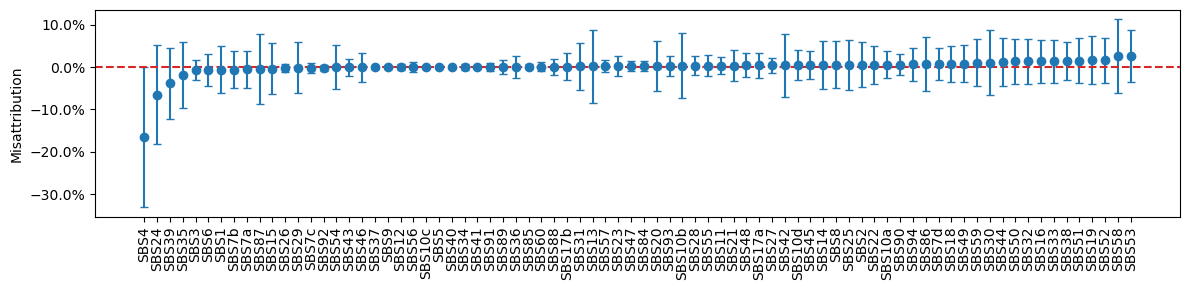

In [13]:
%matplotlib inline
f = plt.figure(figsize=(12, 3))
plt.ylabel(r'Misattribution')
idx = e_signature.sort_values().index
plt.errorbar(idx, e_signature.loc[idx], yerr=e_std.loc[idx], fmt='o', capsize=3)
# Rotate x-labels bij 90 degrees.
plt.xticks(rotation=90)
# Add percentage to y-labels.
# Plot horizontal line at y=0.
plt.axhline(y=0, color='tab:red', linestyle='--')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
# Make the xlabels "SBS4" and "SBS87" bold.
for l in ax.get_xticklabels():
    if l.get_text() in ['SBS4', 'SBS87']:
        l.set_fontweight('bold')
plt.tight_layout()


f.savefig('figs/misattribution.png', bbox_inches='tight')
f.savefig('figs/misattribution.pdf', bbox_inches='tight')
f.savefig('figs/misattribution.svg', bbox_inches='tight')
f.savefig('figs/misattribution.eps', bbox_inches='tight')

Where do the misattributed SBS4 mutations end up?

In [14]:
def multiple_testing_correction(correlation: pd.Series, p_values: pd.Series, negative_only: bool = True) -> pd.DataFrame:
    """Apply multiple testing corretion to p-values."""
    # Use statsmodel to apply Benjamini-Hochberg correction for multiple testing.
    output_correlation = pd.DataFrame({'correlation': correlation, 'pvalue': p_values}).sort_values('correlation', ascending=True)
    # Only negative correlations.
    if negative_only:
        output_correlation = output_correlation[output_correlation['correlation'] < 0]
    output_correlation['reject'], output_correlation['pvalue_corrected'] = fdrcorrection(output_correlation['pvalue'])
    return output_correlation

In [15]:
# Compute Kendall-tau correlation and p-values.
cor_sign, pvalues = kendall_tau_correlation(delta_signature)
cor_sign['SBS24'].sort_values()

SBS14    -0.177284
SBS47    -0.172694
SBS29    -0.156630
SBS89    -0.137040
SBS93    -0.134873
            ...   
SBS3      0.205230
SBS34     0.281103
SBS5           NaN
SBS10c         NaN
SBS40          NaN
Name: SBS24, Length: 78, dtype: float64

In [16]:
negative_cor_sbs4 = multiple_testing_correction(cor_sign['SBS4'], pvalues['SBS4'])
negative_cor_sbs4[negative_cor_sbs4 ['reject']].to_clipboard()
negative_cor_sbs4[negative_cor_sbs4 ['reject']]

correlation  pvalue  reject  pvalue_corrected
SBS35    -0.248384  0.0007    True            0.0357

**Conclusion**: Misattributions at SBS4 primarily end up at SBS35.

Also look for misattributions of SBS87.

In [17]:
cor_sbs87 = pd.DataFrame({'correlation': cor_sign['SBS87'], 'pvalue': pvalues['SBS87']}).sort_values('correlation', ascending=True)
negative_cor_sbs87 = cor_sbs87[cor_sbs87['correlation'] < 0]
negative_cor_sbs87['reject'], negative_cor_sbs87['pvalue_corrected'] = fdrcorrection(negative_cor_sbs87['pvalue'])

/tmp/ipykernel_13569/3662956782.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cor_sbs87['reject'], negative_cor_sbs87['pvalue_corrected'] = fdrcorrection(negative_cor_sbs87['pvalue'])
/tmp/ipykernel_13569/3662956782.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cor_sbs87['reject'], negative_cor_sbs87['pvalue_corrected'] = fdrcorrection(negative_cor_sbs87['pvalue'])


In [18]:
negative_cor_sbs87 = multiple_testing_correction(cor_sign['SBS87'], pvalues['SBS87'])
negative_cor_sbs87[negative_cor_sbs87['reject']].to_clipboard()
negative_cor_sbs87[negative_cor_sbs87['reject']]

Empty DataFrame
Columns: [correlation, pvalue, reject, pvalue_corrected]
Index: []

**Conclusion**: SBS87 mutations are not significantly misattributed.

Lets also look at a few other signatures that had a higher false negative rate than theoreticall predicted.

In [19]:
negative_cor_sbs24 = multiple_testing_correction(cor_sign['SBS24'], pvalues['SBS24'])
negative_cor_sbs24[negative_cor_sbs24['reject']]

Empty DataFrame
Columns: [correlation, pvalue, reject, pvalue_corrected]
Index: []

In [20]:
negative_cor_sbs35 = multiple_testing_correction(cor_sign['SBS35'], pvalues['SBS35'])
negative_cor_sbs35[negative_cor_sbs35['reject']]

correlation  pvalue  reject  pvalue_corrected
SBS4    -0.248384  0.0007    True            0.0273

In [21]:
negative_cor_sbs39 = multiple_testing_correction(cor_sign['SBS39'], pvalues['SBS39'])
negative_cor_sbs39[negative_cor_sbs39['reject']]

Empty DataFrame
Columns: [correlation, pvalue, reject, pvalue_corrected]
Index: []

In [22]:
negative_cor_sbs15 = multiple_testing_correction(cor_sign['SBS15'], pvalues['SBS15'])
negative_cor_sbs15[negative_cor_sbs15['reject']]

Empty DataFrame
Columns: [correlation, pvalue, reject, pvalue_corrected]
Index: []